# B_c_3_Test_Statistiques

Dans cette partie, nous voulons utiliser des méthodes statistiques pour caractériser les données que nous avons obtenues, de même que d'évaluer les liens entre nos différentes séries chronologiques de données (causalité).

Pour effectuer cette analyse, nous utiliserons la méthode présentée par des étudiants aux PhD en sciences des données à l'*Asian Institute of Management* en 2020. (Dajac, C. V. G. et al. (2020). Time Series Analysis Handbook. Repéré à https://phdinds-aim.github.io/time_series_handbook/) 

Nous tenterons aussi de réaliser une régression linéaire sur les données de demande MW et de DeltaTemp. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
from references import colors_pal
from src.visualization import *
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from patsy import dmatrices
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import (
    kpss,
    grangercausalitytests,
)
import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None

In [2]:
# %load_ext jupyter_black

import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=55,
    target_version=black.TargetVersion.PY311,
)

In [3]:
path_to_interim_data = "../data/interim/"
demande_meteo_parquet = "demande_meteo.parquet"

df_import = pd.read_parquet(
    path=os.path.join(
        path_to_interim_data, demande_meteo_parquet
    ),
    engine="pyarrow",
)
df = df_import["20190101":"20221231"]
df["DeltaTemp"] = abs(df["Temp"] - 18)

df = df.dropna()
df.head()

,MW,Temp,DeltaTemp
date,,,
2019-01-01 01:00:00,23762.55,0.0,18.0
2019-01-01 02:00:00,23830.23,-0.2,18.2
2019-01-01 03:00:00,23608.07,-0.5,18.5
2019-01-01 04:00:00,23562.48,-1.0,19.0
2019-01-01 05:00:00,23546.16,-1.1,19.1


## Type de données chronologiques (*timeseries*)

![](https://av-eks-blogoptimized.s3.amazonaws.com/39815Components%20of%20Time%20Series%20Analysis.png)  

**Source** : Pandian, S. (2021, 23 octobre). Time Series Analysis and Forecasting | Data-Driven Insights (Updated 2023). Analytics Vidhya. Repéré à https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/

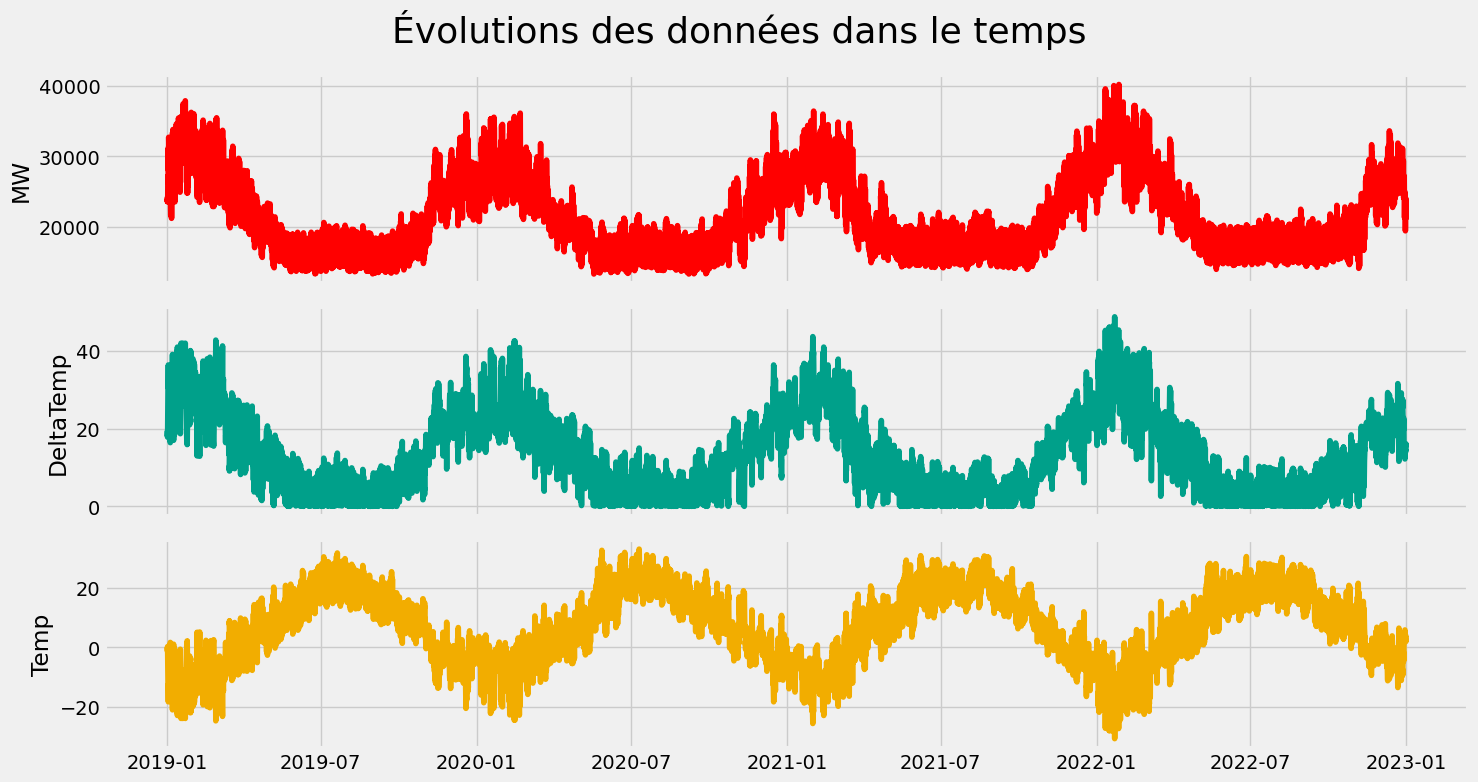

In [4]:
plot_cols = ["MW", "DeltaTemp", "Temp"]
fig, ax = plt.subplots(
    len(plot_cols), figsize=(15, 8), sharex=True
)
df[plot_cols].plot(
    subplots=True,
    legend=False,
    ax=ax,
    color=colors_pal,
)
for a in range(len(ax)):
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel("")
plt.suptitle(
    "Évolutions des données dans le temps", fontsize=26
)
plt.tight_layout()
plt.show()

Nous pouvons bien voir sur ce graphique à quel point les profils sont similaires entre la demande en MW et la différence de température (DeltaTemp). 

Dans les 2 cas, nous pouvons bien voir la saisonnalité des données (cycle de 1 an) et la tendance (*trend*) qui est très neutre (pas de tendance haussière facilement visible).  

## Phénomène stationnaire

![](https://av-eks-blogoptimized.s3.amazonaws.com/99388Stationary%20Vs%20Non-Stationary.png)

**Source** : Pandian, S. (2021, 23 octobre). Time Series Analysis and Forecasting | Data-Driven Insights (Updated 2023). Analytics Vidhya. Repéré à https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/

Nous pouvons aussi voir que nos données ne sont pas nécessairement stationnaires, car il y a des variations qui ne sont pas seulement cycliques.

Nous pouvons valider le tout avec le test de Kwiatkowski–Phillips–Schmidt–Shin (KPSS).

> In econometrics, Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests are used for testing a null hypothesis that an observable time series is stationary around a deterministic trend (i.e. trend-stationary) against the alternative of a unit root (https://en.wikipedia.org/wiki/KPSS_test)

**<big>L'hypothèse nulle de ce test (H0) est que les données sont stationnaires.</big>** 

In [5]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = (
        [],
        [],
        [],
        [],
    )
    for c in data_df.columns:
        kpss_res = kpss(
            data_df[c].dropna(), regression="c"
        )
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]["1%"])
        cv_2p5pct.append(kpss_res[3]["2.5%"])
        cv_5pct.append(kpss_res[3]["5%"])
        cv_10pct.append(kpss_res[3]["10%"])
    kpss_res_df = pd.DataFrame(
        {
            "Test statistic": test_stat,
            "p-value": p_val,
            "Critical value - 1%": cv_1pct,
            "Critical value - 2.5%": cv_2p5pct,
            "Critical value - 5%": cv_5pct,
            "Critical value - 10%": cv_10pct,
        },
        index=data_df.columns,
    ).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [6]:
kpss_test(df)

,MW,Temp,DeltaTemp
Test statistic,0.5300,0.8493,0.9328
p-value,0.0349,0.0100,0.0100
Critical value - 1%,0.7390,0.7390,0.7390
Critical value - 2.5%,0.5740,0.5740,0.5740
Critical value - 5%,0.4630,0.4630,0.4630
Critical value - 10%,0.3470,0.3470,0.3470


Si la valeur p est inférieure au seuil de signification défini (disons 5 %), l'hypothèse nulle est rejetée. 

Dans notre cas, cela veut dire que **les données ne sont pas stationnaires**. 

Vérifions la même chose avec l'analyse du *lagplot*. 

In [7]:
def lag_plots(data_df, lag):
    f, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(15, 5)
    )

    lag_plot(
        data_df[data_df.columns[0]], ax=ax1, lag=lag
    )
    ax1.set_title(data_df.columns[0])

    lag_plot(
        data_df[data_df.columns[1]], ax=ax2, lag=lag
    )
    ax2.set_title(data_df.columns[1])

    lag_plot(
        data_df[data_df.columns[2]], ax=ax3, lag=lag
    )
    ax3.set_title(data_df.columns[2])

    ax1.set_ylabel("$y_{t+1}$")
    ax1.set_xlabel("$y_t$")
    ax2.set_ylabel("$y_{t+1}$")
    ax2.set_xlabel("$y_t$")
    ax3.set_ylabel("$y_{t+1}$")
    ax3.set_xlabel("$y_t$")

    plt.tight_layout()

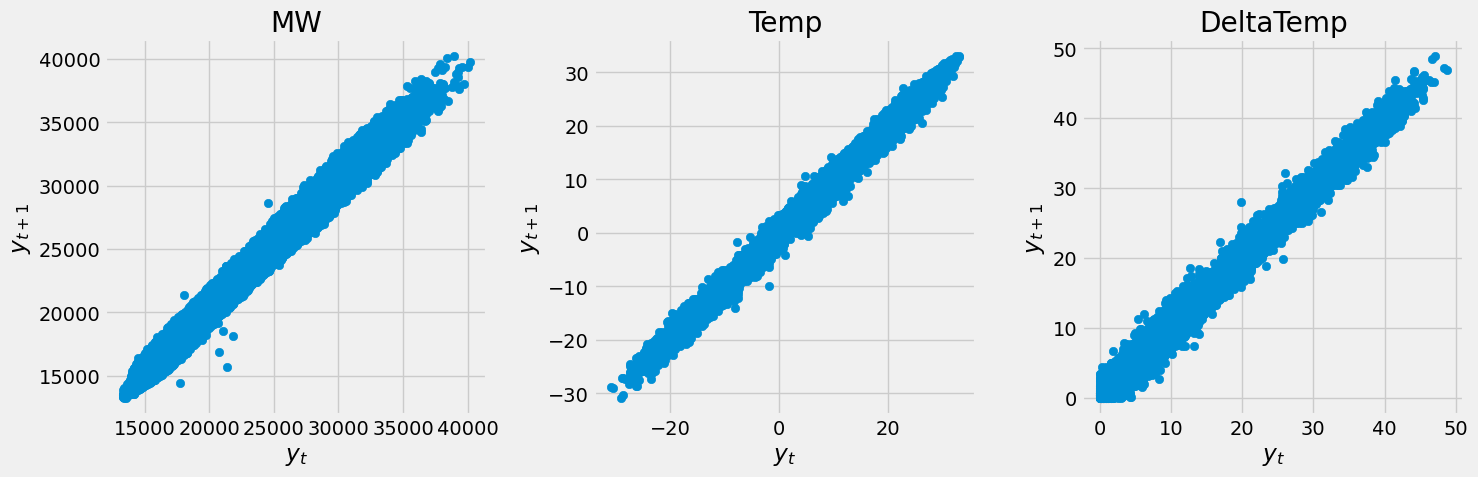

In [8]:
# Lag d'une heure
lag_plots(df, 1)

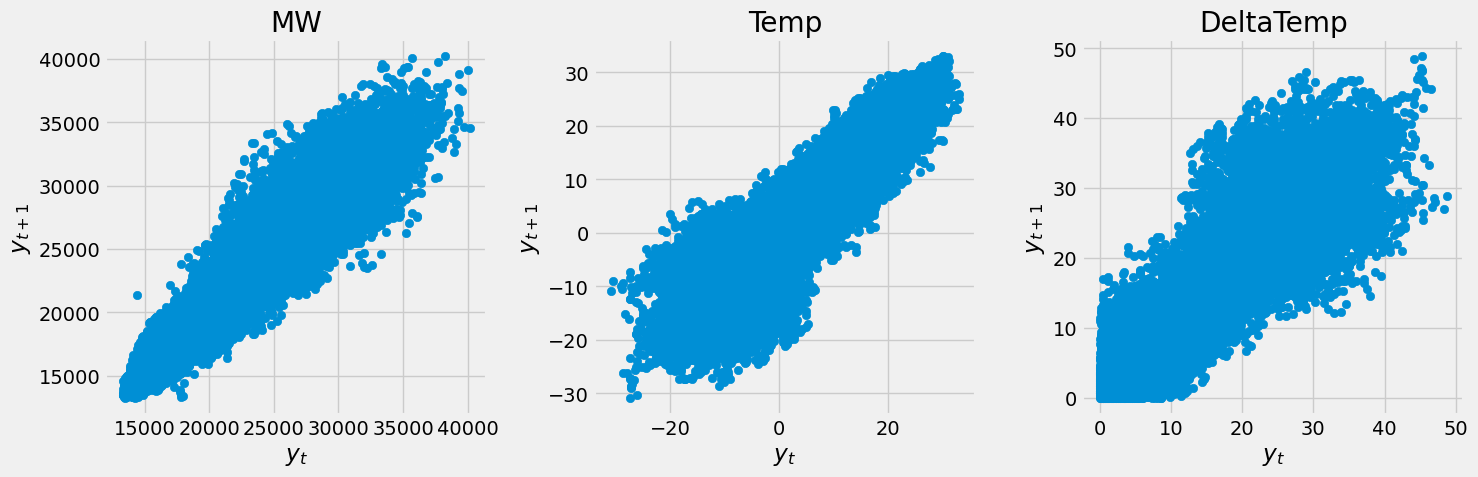

In [9]:
# Lag d'une journée
lag_plots(df, 24)

Nous pouvons bien voir que la valeur au temps Y<sub>t+1</sub> est influencée par le temps Y<sub>t</sub> à cause de la tendance clairement linéaire des graphiques d'une heure et de 24 heures.

### Différenciation 

Nous appliquons la différenciation afin de rendre nos données stationnaires, ce qui permettra le prochain test. 

> This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.  (https://otexts.com/fpp2/stationarity.html)

In [10]:
diff_df = df.copy()
diff_df["Temp"] = df["Temp"] - df["Temp"].shift(1)
diff_df["DeltaTemp"] = df["DeltaTemp"] - df[
    "DeltaTemp"
].shift(1)
diff_df["MW"] = df["MW"] - df["MW"].shift(1)
diff_df = diff_df.dropna()
diff_df

,MW,Temp,DeltaTemp
date,,,
2019-01-01 02:00:00,67.68,-0.2,0.2
2019-01-01 03:00:00,-222.16,-0.3,0.3
2019-01-01 04:00:00,-45.59,-0.5,0.5
2019-01-01 05:00:00,-16.32,-0.1,0.1
2019-01-01 06:00:00,206.74,0.1,-0.1
...,...,...,...
2022-12-31 19:00:00,-614.03,0.0,0.0
2022-12-31 20:00:00,-754.64,0.6,-0.6
2022-12-31 21:00:00,-623.21,-0.4,0.4


Revérifions les graphiques dans le temps, lagplots et le test de KPSS. 

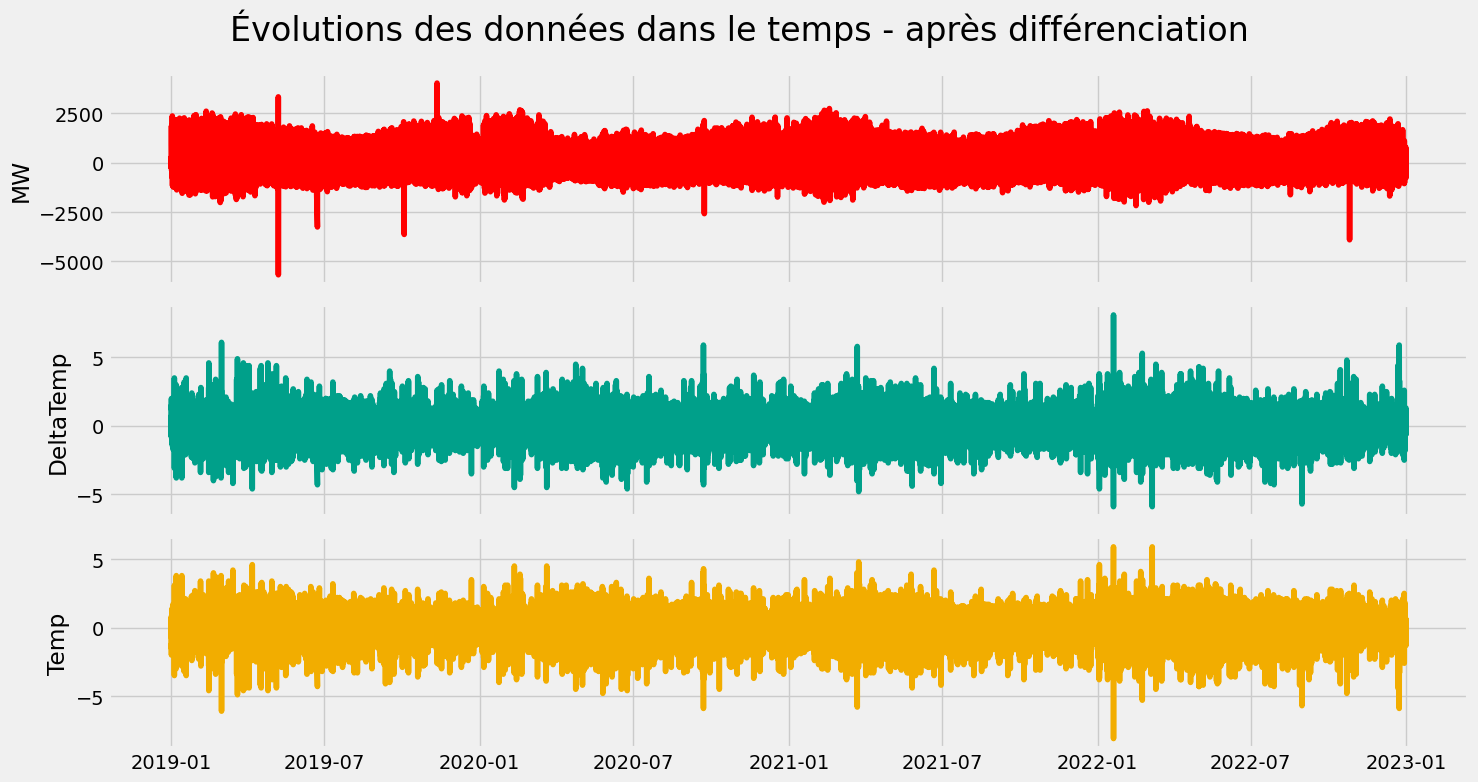

In [11]:
fig, ax = plt.subplots(3, figsize=(15, 8), sharex=True)
plot_cols = ["MW", "DeltaTemp", "Temp"]
diff_df[plot_cols].plot(
    subplots=True,
    legend=False,
    ax=ax,
    color=colors_pal,
)
for a in range(len(ax)):
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel("")
plt.suptitle(
    "Évolutions des données dans le temps - après différenciation",
    fontsize=24,
)
plt.tight_layout()
plt.show()

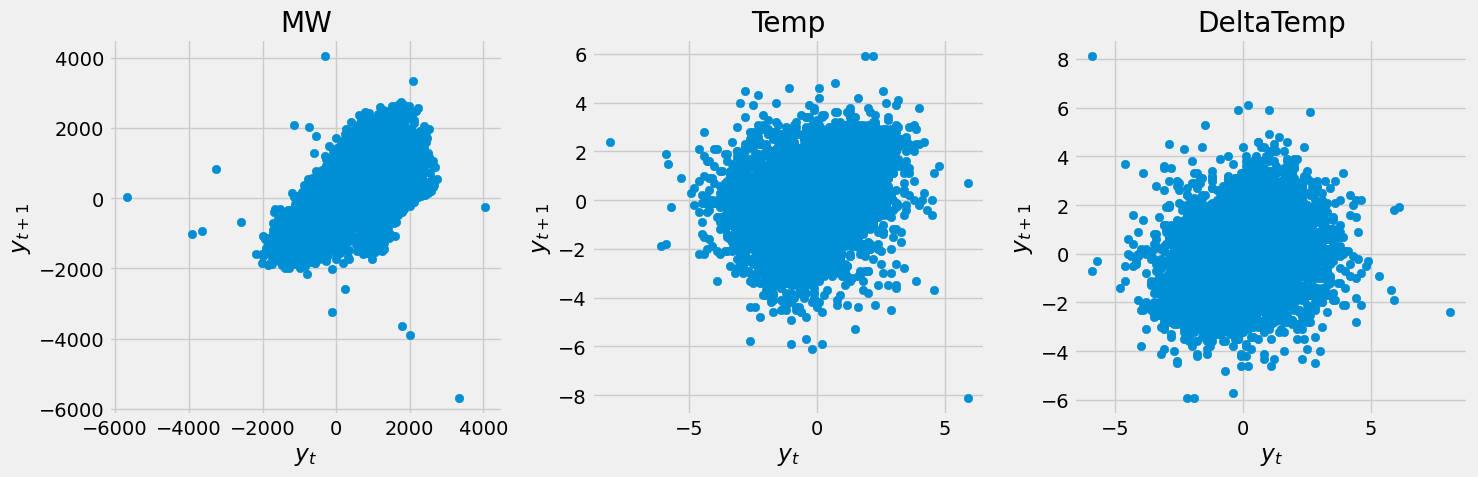

In [12]:
lag_plots(diff_df, 1)

In [13]:
kpss_test(diff_df)

,MW,Temp,DeltaTemp
Test statistic,0.0225,0.0122,0.0095
p-value,0.1000,0.1000,0.1000
Critical value - 1%,0.7390,0.7390,0.7390
Critical value - 2.5%,0.5740,0.5740,0.5740
Critical value - 5%,0.4630,0.4630,0.4630
Critical value - 10%,0.3470,0.3470,0.3470


Les valeurs p étant supérieures à notre seuil de 0.05, nous ne pouvons rejeter l'hypothèse nulle.

Étant donné le graphique qui n'affiche plus de tendance non plus, nous pouvons utiliser ces valeurs différenciées pour la suite des tests, comme étant **stationnaires**. 

### Lien de causalité (Granger Causality)

> Est-ce que l'évolution de la température dans le temps a un lien de causalité avec la demande électrique ?

Nous pouvons utiliser le test de causalité de Granger afin de déterminer si les séries chronologiques, la température dans notre cas, a un effet de causalité sur une autre série chronologique, soit la demande électrique.  

![Granger-Causality](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/GrangerCausalityIllustration.svg/1920px-GrangerCausalityIllustration.svg.png)

> When time series X Granger-causes time series Y, the patterns in X are approximately repeated in Y after some time lag (two examples are indicated with arrows). Thus, past values of X can be used for the prediction of future values of Y.

**Source** : https://en.wikipedia.org/wiki/Granger_causality

Nous débutons par une analyse VAR (Vector Autoregressive) pour sélectionner l'ordre du facteur p.

> Fitting a VAR model involves the selection of a single parameter: the model order or lag length 𝑝. The most common approach in selecting the best model is choosing the 𝑝 that minimizes one or more information criteria evaluated over a range of model orders.

AIC     59
BIC     50
HQIC    52
FPE     59
dtype: int64


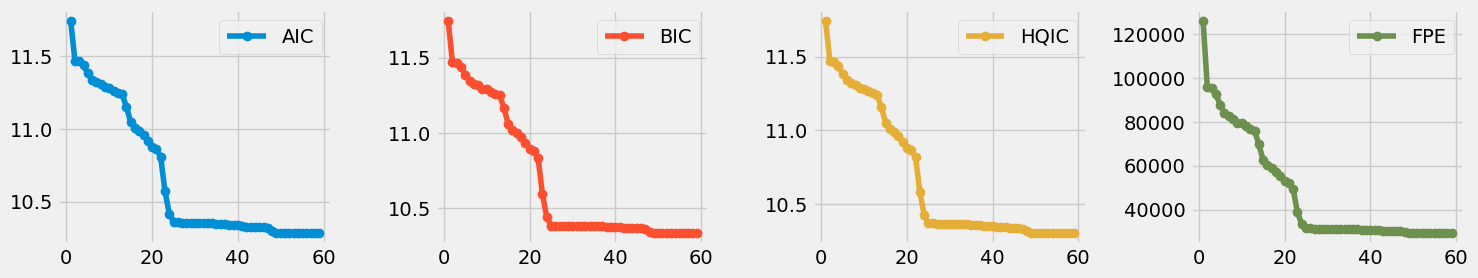

In [14]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df)
    p = np.arange(1, 60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame(
        {
            "AIC": aic,
            "BIC": bic,
            "HQIC": hqic,
            "FPE": fpe,
        },
        index=p,
    )
    fig, ax = plt.subplots(
        1, 4, figsize=(15, 3), sharex=True
    )
    lags_metrics_df.plot(
        subplots=True, ax=ax, marker="o"
    )
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))


select_p(diff_df[["DeltaTemp", "MW"]])

Nous voyons que notre valeur p minimale débute à environ 24, ce qui fait du sens étant donné que c'est le nombre d'heures dans une journée !

In [15]:
p = 24
model = VAR(diff_df[["DeltaTemp", "MW"]])
var_model = model.fit(p)

In [16]:
def granger_causation_matrix(
    data,
    variables,
    p,
    test="ssr_chi2test",
    verbose=False,
):
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(
        np.zeros((len(variables), len(variables))),
        columns=variables,
        index=variables,
    )
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(
                data[[r, c]], p, verbose=False
            )
            p_values = [
                round(
                    test_result[i + 1][0][test][1], 4
                )
                for i in range(p)
            ]
            if verbose:
                print(
                    f"Y = {r}, X = {c}, P Values = {p_values}"
                )
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + "_x" for var in variables]
    df.index = [var + "_y" for var in variables]
    return df

In [17]:
granger_causation_matrix(
    diff_df[["DeltaTemp", "MW"]],
    diff_df[["DeltaTemp", "MW"]].columns,
    p,
)

,DeltaTemp_x,MW_x
DeltaTemp_y,1.0,0.0
MW_y,0.0,1.0


> If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

Nous pouvons voir que les MW et le DeltaTemp ont une relation de causalité une envers l'autre selon les résultats de tests de Granger.

Par contre, nous devons nous questionner sur ce résultat. Nous pouvons voir que les deux séries (DeltaTemp, MW) sont tellement corrélées entres elles qu'elles peuvent avoir l'air d'avoir un effet de causalité l'une envers l'autre.  Par contre, la logique nous permet de croire que la température a un impact sur la demande électrique (*Il fait froid, je dois chauffer ma maison*), mais l'inverse n'est pas nécessairement vrai.

Par contre, nous pouvons croire que la température, ou plutôt le delta de température, sera un excellent indicateur de la demande électrique dans les étapes subséquentes. 

---

## Régressions

Nous avons vu dans l'analyse exploratoire préliminaire que les données de DeltaTemp et MW peuvent être représentées par une forme linéaire sur un graphique de points. 

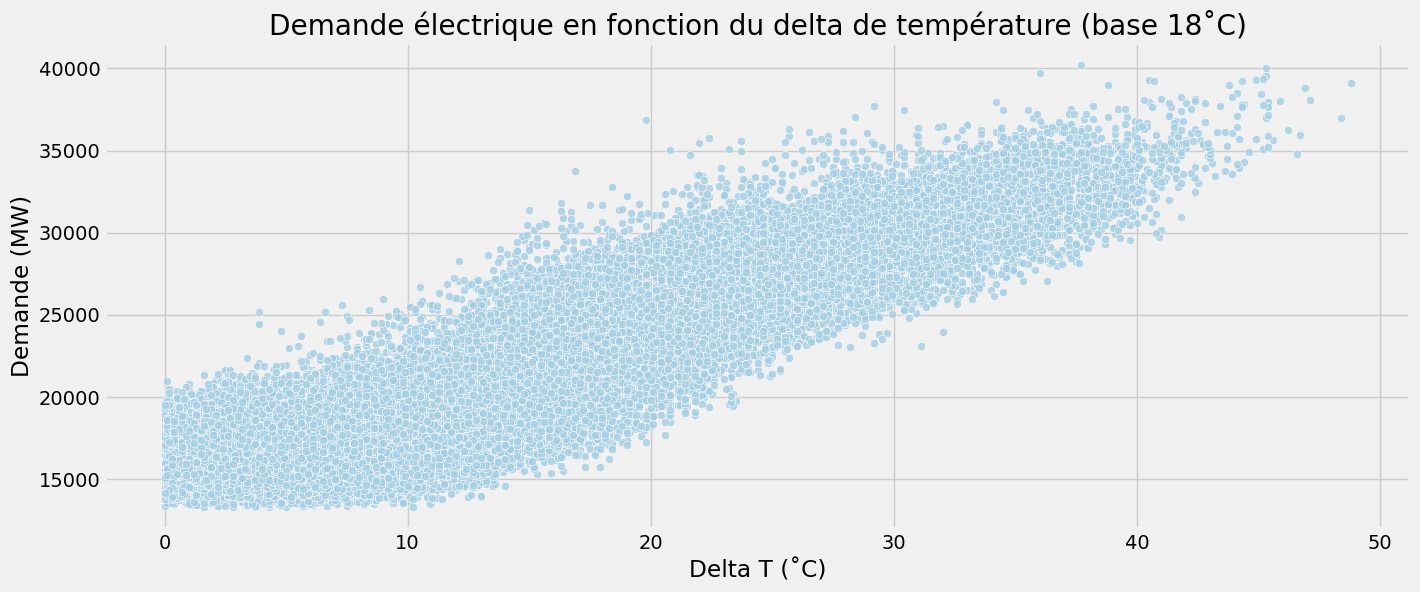

In [18]:
plt.figure(figsize=(15, 6))
sns.set_palette("Paired")
ax = sns.scatterplot(
    data=df.reset_index(drop=True),
    y="MW",
    x="DeltaTemp",
    alpha=0.8,
)
ax.set(
    title="Demande électrique en fonction du delta de température (base 18˚C)",
    xlabel="Delta T (˚C)",
    ylabel="Demande (MW)",
)

plt.show()

Notre intention dans cette section est de valider la présence d'une régression et d'en estimer la courbe. 

In [19]:
# Ref : https://www.statsmodels.org/stable/gettingstarted.html

# OLS : Linear Regression - Ordinary Least Squares

df_stats = df.reset_index(drop=True).dropna()
df_stats = df_stats[["MW", "DeltaTemp"]]

y, X = dmatrices(
    "MW ~ DeltaTemp",
    data=df_stats,
    return_type="dataframe",
)
mod = sm.OLS(y, X)  # Describe model
res = mod.fit()  # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MW   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                 1.322e+05
Date:                Mar, 21 nov 2023   Prob (F-statistic):               0.00
Time:                        21:46:35   Log-Likelihood:            -3.2222e+05
No. Observations:               35018   AIC:                         6.445e+05
Df Residuals:                   35016   BIC:                         6.445e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.545e+04     21.033    734.668      0.000    1.54e+04    1.55e+04
DeltaTemp    457.2044      1.257    363.635      0.000     454.740     459.669
==============================================================================
Omnibus:                      236.672   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.339
Skew:                          -0.202   Prob(JB):                     3.93e-53
Kurtosis:                       3.041   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Analyse des résultats de régression

> - Adjusted. R-squared reflects the fit of the model. R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
> - const coefficient is your Y-intercept. 
> - std err reflects the level of accuracy of the coefficients. The lower it is, the higher is the level of accuracy
> - P >|t| is your p-value. A p-value of less than 0.05 is considered to be statistically significant
> Source  : https://datatofish.com/statsmodels-linear-regression/

Nous avons une valeur R<sup>2</sup>  de 0.791, ce qui est relativement élevé et des valeurs P inférieur à 0.05. Le modèle est intéressant en régression liniéaire. 

Voyons voir comment nous pouvons le représenter graphiquement.

In [20]:
x_0 = res.params[0]
a_x = res.params[1]

print(
    f"Formule de régression : MW = {x_0:.02f} + {a_x:.02f} • DeltaTemp"
)
print(f"R-Squared = {res.rsquared:0.4f}")

Formule de régression : MW = 15452.56 + 457.20 • DeltaTemp
R-Squared = 0.7906


### Graphique de points avec la ligne de régression calculée

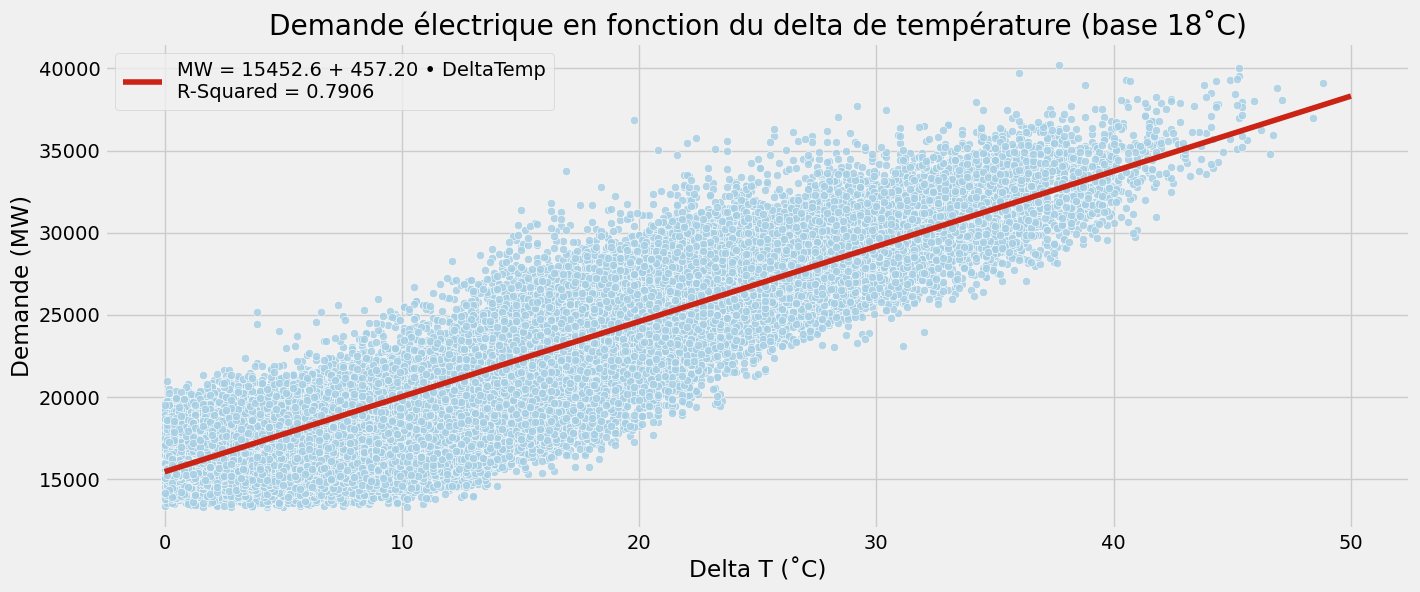

In [21]:
axe_x = np.linspace(0, 50, 500)

plt.figure(figsize=(15, 6))
sns.set_palette("Paired")
ax = sns.scatterplot(
    data=df.reset_index(drop=True),
    y="MW",
    x="DeltaTemp",
    alpha=0.8,
)
ax.set(
    title="Demande électrique en fonction du delta de température (base 18˚C)",
    xlabel="Delta T (˚C)",
    ylabel="Demande (MW)",
)
sns.lineplot(
    x=axe_x,
    y=x_0 + a_x * axe_x,
    color=colors_pal[6],
    label=f"MW = {x_0:.01f} + {a_x:.02f} • DeltaTemp\nR-Squared = {res.rsquared:0.4f}",
).legend(loc="best")
plt.show()

Nous voyons que les points ne sont pas distribués également de part et autres de la ligne de régression. Vers 10C, il y a beaucoup plus de points sous la ligne avec qu'ils sont plus au-dessus dans les environs de 30X. 

Nous pouvons aussi cibler seulement une période d'été et une d'hiver. 

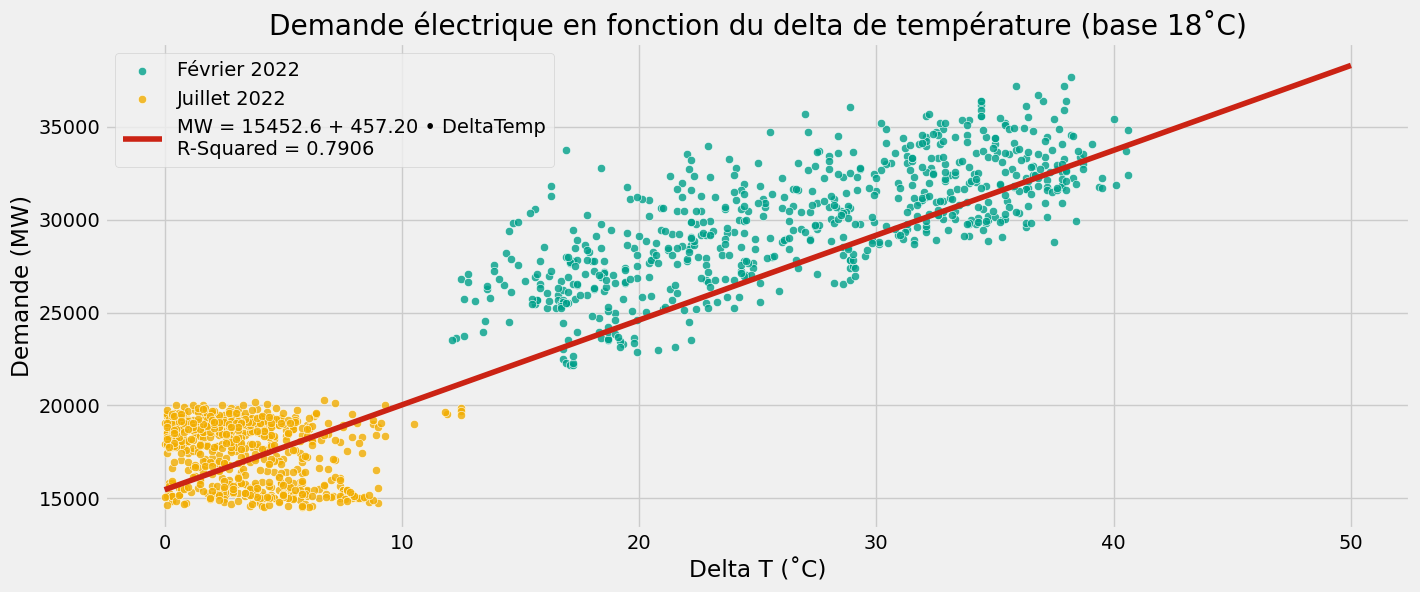

In [22]:
plt.figure(figsize=(15, 6))
sns.set_palette("Paired")
ax = sns.scatterplot(
    data=df["20220201":"20220228"].reset_index(
        drop=True
    ),
    y="MW",
    x="DeltaTemp",
    alpha=0.8,
    color=colors_pal[1],
    label="Février 2022",
)
ax = sns.scatterplot(
    data=df["20220601":"20220630"].reset_index(
        drop=True
    ),
    y="MW",
    x="DeltaTemp",
    alpha=0.8,
    color=colors_pal[2],
    label="Juillet 2022",
)
ax.set(
    title="Demande électrique en fonction du delta de température (base 18˚C)",
    xlabel="Delta T (˚C)",
    ylabel="Demande (MW)",
)
sns.lineplot(
    x=axe_x,
    y=x_0 + a_x * axe_x,
    color=colors_pal[6],
    label=f"MW = {x_0:.01f} + {a_x:.02f} • DeltaTemp\nR-Squared = {res.rsquared:0.4f}",
).legend(loc="best")
plt.show()

### Calcul du MSE, RMSE et MAE
Dans le but de pouvoir comparer avec nos résultats futurs, calculons les MSE, RMSE et MAE comme indicateur de qualité de la régression.

> La Root Mean Squared Error (RMSE) et la Mean Squared Error (MSE) sont les métriques de régression les plus courantes. Du fait de leurs propriétés de régularité, ce sont les métriques historiques pour optimiser les modèles de régression comme la régression linéaire.
> La MAE est la métrique de régression la plus interprétable, ce qui en fait une métrique populaire malgré son manque de régularité.
> Source : https://kobia.fr/regression-metrics-quelle-metrique-choisir

In [23]:
Y_pred = x_0 + a_x * df.DeltaTemp.values
Y_true = df.MW.values

In [24]:
MSE = mse(Y_true, Y_pred)
RMSE = math.sqrt(MSE)
MAE = mae(Y_true, Y_pred)

In [25]:
print(
    f"Le MSE est de {MSE:0.1f}, le RMSE est de {RMSE:0.1f} et le MAE de {MAE:0.1f} pour un calcul sur {len(Y_true)} valeurs."
)

Le MSE est de 5754212.5, le RMSE est de 2398.8 et le MAE de 1905.7 pour un calcul sur 35018 valeurs.


Le but de notre modélisation à venir sera d'améliorer ces résultats à partir d'un modèle simple, qui ne prennent pas en compte bien des paramètres du modèle. 

# Conclusion

Dans cette partie du travail, nous avons utilisé des visualisations pour caractériser les tendances, la cyclicité et la saisonnalité des données chronologiques.

Nous avons aussi utilisé des tests statistiques tels que Kwiatkowski–Phillips–Schmidt–Shin (KPSS) pour caractériser nos données chronologiques. Nous avons pu déterminer que nos données n'étaient pas stationnaires et que nous devions y appliquer un processus de différenciation pour les rendre stationnaires. 

Nous avons pu par la suite valider les liens de causalités avec le test de Granger. Ce test nous a dit que la température (ou la différence de température avec 18C) causait la demande, ce qui fait du sens logiquement.  Il nous a aussi dit le contraire, où la demande causerait la température, ce qui ne fait pas de sens. Nous pouvons voir graphiquement que la très grande corrélation entre ces deux séries de données peuvent entraîner le test à affirmer ces résultats. 

Nous avons terminé cette partie en réalisant une régression linéaire sur nos données, en calculant des paramètres de performance de cette régression et en visualisant le résultat.

Ceci conclut la seconde partie du projet et nous pourrons compléter le travail noté 2 dans les prochains jours. 